In [1]:
import pyLabFEM as FE
from pyLabMaterial import Material
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Yield loci of anisotropic reference material and isotropic material


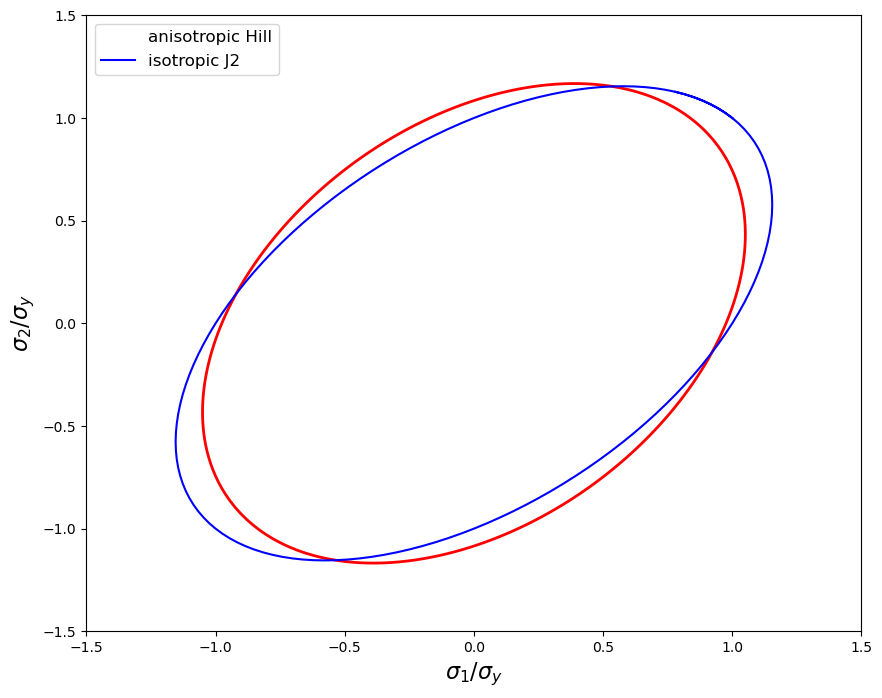

In [2]:
'define two elastic-plastic materials with identical yield strength and elastic properties'
E=200.e3
nu=0.3
sy = 150.
'anistropic Hill-material as reference'
mat_h = Material(name='anisotropic Hill')
mat_h.elasticity(E=E, nu=nu)
mat_h.plasticity(sy=sy, hill=[0.7,1.,1.4], drucker=0., khard=0.)
'isotropic material for ML flow rule'
mat_ml = Material(name='ML flow rule')
mat_ml.elasticity(E=E, nu=nu)
mat_ml.plasticity(sy=sy, hill=[1.,1.,1.], drucker=0., khard=0.)
print('Yield loci of anisotropic reference material and isotropic material')
ax = mat_h.plot_yield_locus(xstart=-1.5, xend=1.5, iso=True)


In [3]:
'Create training data in deviatoric stress space for components seq and theta'
def create_data(N, mat, extend=False, rand=False):
    # create stresses along unit circle normal to hydrostatic axis
    if not rand:
        theta = np.linspace(-np.pi, np.pi, N)
    else:
        theta = 2.*(np.random.rand(N)-0.5)*np.pi
    sig = FE.sp_cart(np.array([np.ones(N)*np.sqrt(3/2), theta]).T)
    offs = 0.01
    x = offs*sig
    N = 23
    for i in range(N):
        hh = offs + (1.4-offs)*(i+1)/N
        x = np.append(x, hh*sig, axis=0)
    if extend:
        # add training points in plastic regime to avoid fallback of SVC decision fct. to zero
        x = np.append(x, 2.*sig, axis=0)
        x = np.append(x, 3.*sig, axis=0)
        x = np.append(x, 4.*sig, axis=0) 
        x = np.append(x, 5.*sig, axis=0)
    'result data for ML yield function (only sign is considered)'
    y = np.sign(mat.calc_yf(x*mat.sy, ana=True))
    return x,y 


In [4]:
'Training and testing data for ML yield function, based on reference Material mat_h'
ndata = 36
ntest = np.maximum(20, int(ndata/10))
x_train, y_train = create_data(ndata, mat_h, extend=True) 
x_test, y_test = create_data(ntest, mat_h, rand=True)
x_train *= mat_h.sy
x_test *= mat_h.sy

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1008, 3) (1008,)
(480, 3) (480,)


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout 
from sklearn.preprocessing import Binarizer
bin = Binarizer()
y_train = bin.transform(y_train.reshape(-1,1))
y_test = bin.transform(y_test.reshape(-1,1))

In [7]:
y_test

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [8]:
model= Sequential()

model.add(Dense(18, activation='relu', input_shape=(3,)))
#model.add(Dropout(0.5))
model.add(Dense(9, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                72        
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 dense_2 (Dense)             (None, 3)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 277 (1.08 KB)
Trainable params: 277 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor],
           verbose=2, epochs = 1000, batch_size = 5)

Epoch 1/1000
202/202 - 0s - loss: 3.1858 - accuracy: 0.5129 - val_loss: 0.7524 - val_accuracy: 0.5104 - 332ms/epoch - 2ms/step
Epoch 2/1000
202/202 - 0s - loss: 0.6227 - accuracy: 0.5992 - val_loss: 0.6718 - val_accuracy: 0.6042 - 109ms/epoch - 540us/step
Epoch 3/1000
202/202 - 0s - loss: 0.5891 - accuracy: 0.6419 - val_loss: 0.6294 - val_accuracy: 0.6521 - 109ms/epoch - 538us/step
Epoch 4/1000
202/202 - 0s - loss: 0.5443 - accuracy: 0.6855 - val_loss: 0.5808 - val_accuracy: 0.7000 - 104ms/epoch - 517us/step
Epoch 5/1000
202/202 - 0s - loss: 0.5276 - accuracy: 0.7073 - val_loss: 0.5669 - val_accuracy: 0.7083 - 104ms/epoch - 517us/step
Epoch 6/1000
202/202 - 0s - loss: 0.4993 - accuracy: 0.7282 - val_loss: 0.5356 - val_accuracy: 0.7146 - 103ms/epoch - 512us/step
Epoch 7/1000
202/202 - 0s - loss: 0.4661 - accuracy: 0.7540 - val_loss: 0.4869 - val_accuracy: 0.7646 - 105ms/epoch - 520us/step
Epoch 8/1000
202/202 - 0s - loss: 0.4431 - accuracy: 0.7748 - val_loss: 0.4783 - val_accuracy: 0.75

In [12]:
y_pred = model.predict(x_test)

15/15 [==============================] - 0s 394us/step


In [13]:
from sklearn.metrics import accuracy_score

binary = Binarizer(threshold = 0.5)
y_pred = binary.transform(y_pred)

In [14]:
print(f"DNN test Accuracy: {accuracy_score(y_test, y_pred)}")

DNN test Accuracy: 0.9916666666666667


In [15]:
y_pred

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

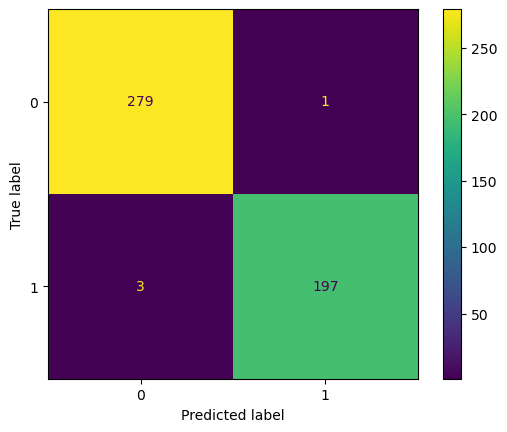

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

In [18]:
x_test.shape

(480, 3)